In [52]:
import scipy as sp
import os
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import linear_model
import plotly.express as px
import plotly
import seaborn as sns


import japanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 乱数seedの固定
np.random.seed(seed=123)

In [53]:
# E-step
def EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec):
    '''
    y[i]
    lambda[k]
    mu[k]
    sigma[k]
    '''
    I = len(y)
    # 中身を初期化せずに配列を作成する関数である。
    # 2行, 1000列の配列を生成
    responsibility = sp.empty((k_size, I))
    
    """for k in sp.arange(k_size):
        norm = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        responsibility[k] = lambda_vec[k] *norm.pdf(y)"""
    
    for k in sp.arange(k_size):
        _beta = X@coef_vec[k]
        _sigma = sigma2_vec[k]
        for i in range(I):
            responsibility[k][i] = np.exp((-(y[i] - _beta[i])**2) / (2*_sigma) )/ np.sqrt(2*np.pi*_sigma)

    responsibility = responsibility / sp.sum(responsibility, axis=0)
    return responsibility

def MStep(k_size, responsibility, y):

    lambda_vec = sp.empty(k_size)
    #mu_vec = sp.empty(k_size)
    coef_vec = []
    sigma2_vec = sp.empty(k_size)

    for k in sp.arange(k_size):
        r_k = responsibility[k]
        coef_vec.append(np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y)
        lambda_vec[k] = sp.sum(r_k) / responsibility.shape[1]
        #mu_vec[k] = sp.sum(r_k * y) / sp.sum(r_k)
        sigma2_vec[k] = sp.sum(r_k * (y - np.mean(X@coef_vec[k]))**2) / sp.sum(r_k)
        
    mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]
        
    return lambda_vec, mu_vec, coef_vec, sigma2_vec

In [54]:
def calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec):
    pdf = sp.zeros_like(x)

    for k in sp.arange(k_size):
        norm_k = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        
        # pdf (Probability density function) 確率密度関数
        # xのときの値を取得
        pdf += lambda_vec[k] * norm_k.pdf(x)
    return pdf

In [55]:
def calc_log_likelihood(X, coef_vec, sigma2_vec, lambda_vec, y):
    """
    norm1 = stats.norm(loc=X@coef_vec[0], scale=np.sqrt(sigma2_vec[0])).pdf(y)
    norm2 = stats.norm(loc=X@coef_vec[1], scale=np.sqrt(sigma2_vec[1])).pdf(y)
    likelihood=lambda_vec[0]*norm1 + lambda_vec[1]*norm2
    log_likelihood = np.sum(np.log(likelihood))
    """
    
    norm1 = np.exp((-(y -X@coef_vec[0])**2) / (2*sigma2_vec[0]) )/ np.sqrt(2*np.pi*sigma2_vec[0])
    norm2 = np.exp((-(y -X@coef_vec[1])**2) / (2*sigma2_vec[1]) )/ np.sqrt(2*np.pi*sigma2_vec[1])
    log_likelihood = responsibility[0]@np.log(norm1) + responsibility[1]@np.log(norm2) + np.sum(responsibility[0]*np.log( lambda_vec[0])+ responsibility[1]*np.log( lambda_vec[1]))

    return log_likelihood

# Config

In [263]:
# 　使用する変数
#FEATS = ["hf", "pop",  "urb", "gdp","dist", "air", "detection"]
#FEATS = ['urb', 'gdp', 'air', 'detection', 'HDI', 'median_age', 'dist_italy']
FEATS =["hf", "pop",  "urb", "gdp","air", "detection", "median_age", "population_density"]
exp_name = "exp13"
memo="dist除く, 人口密度, 年齢中央値の追加"


NEW_DIR_PATH = f'output/{exp_name}/'
os.mkdir(NEW_DIR_PATH)

# データの作成

In [282]:
#df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
#df = pd.read_csv("../../data/data_covid_fix_name_code_coordinate_ltaly.csv").iloc[:,1:]
df = pd.read_csv("../../data/data_covid_fix_name_code_coordinate_ltaly_medianage_hdi_density.csv")
df = df.dropna().reset_index(drop=True)

In [283]:
df.head(2)

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,...,cumul,air,code3,code2,lat,lon,dist_italy,median_age,HDI,population_density
0,Albania,2866376,60.319,13364.155397,6.996524e+06,7.84,8.005411,7.67,70,74.3,...,108641,303.14,ALB,AL,41.327546,19.818698,613446.033335,36.200001,0.792,104.612263
1,Algeria,42228429,72.629,15481.787620,9.108277e+06,4.99,5.201489,4.77,58,12.0,...,80272,6442.44,DZA,DZ,36.753768,3.058756,993497.660060,27.500000,0.746,17.730075


In [284]:
y=df["date_first"].values
#plt.hist(y, density=True)

### スケーリング(標準化)

In [285]:
df["dist_gdp"] = df["dist"] * df["gdp"]
df["dist_air"] = df["dist"] * df["air"]

df["log_pop"] = np.log(df["pop"])
df["log_air"] = np.log(df["air"])

tmp = df[[ "date_first"]+FEATS]
tmp.index = df["country"]
tmp

,date_first,hf,pop,urb,gdp,air,detection,median_age,population_density
country,,,,,,,,,
Albania,70,7.84,2866376,60.319,13364.155397,303.14,74.3,36.200001,104.612263
Algeria,58,4.99,42228429,72.629,15481.787620,6442.44,12.0,27.500000,17.730075
Angola,83,5.40,30809762,65.514,6452.355165,76.94,17.9,16.400000,24.713052
Argentina,65,6.86,44494502,91.870,20610.568550,1516.63,74.9,30.799999,16.258510
Australia,26,8.62,24992369,86.012,51663.365095,75667.65,97.3,37.400002,3.247871
...,...,...,...,...,...,...,...,...,...
Venezuela,76,3.80,28870195,88.208,18102.500000,2137.77,8.7,27.400000,32.730792
Vietnam,25,6.29,95540395,35.919,7447.814334,47049.67,57.4,30.400000,308.125246
Yemen,102,4.30,28498687,36.642,2575.126385,336.31,9.0,19.200001,53.977853


In [286]:
X = df[FEATS]
#X["population_density"] = np.log(X["population_density"])
#X["population_density"] = np.log(X["population_density"])
sscaler = preprocessing.StandardScaler() # インスタンスの作成
sscaler.fit(X)    
X = sscaler.transform(X) # xを変換
pd.DataFrame(X, columns=FEATS)

,hf,pop,urb,gdp,air,detection,median_age,population_density
0,0.848173,-0.311439,-0.063938,-0.433684,-0.299479,1.168601,0.713791,-0.147567
1,-1.758643,0.017707,0.497620,-0.343016,-0.222283,-1.629438,-0.261875,-0.273901
2,-1.383627,-0.077776,0.173047,-0.729617,-0.302324,-1.364456,-1.506690,-0.263747
3,-0.048206,0.036656,1.375357,-0.123424,-0.284221,1.195549,0.108205,-0.276041
4,1.561618,-0.126421,1.108126,1.206121,0.648163,2.201585,0.848366,-0.294959
...,...,...,...,...,...,...,...,...
143,-2.847103,-0.093995,1.208304,-0.230809,-0.276411,-1.777649,-0.273089,-0.252089
144,-0.569569,0.463501,-1.177019,-0.686996,0.288317,0.409582,0.063347,0.148358
145,-2.389767,-0.097101,-1.144037,-0.895623,-0.299062,-1.764175,-1.192682,-0.221194
146,-0.386634,-0.190312,-0.830230,-0.825030,-0.303179,-1.184806,-1.428188,-0.265741


In [287]:
# データを早期、晩期に分割
y_early = df["date_first"][df["date_first"]<40]
y_late = df["date_first"][df["date_first"]>40]

x_early = X[df["date_first"]<40]
x_late = X[df["date_first"]>40]

# 初期値の設定  
- Rで計算済み

In [288]:
clf_early = linear_model.LinearRegression()
clf_early.fit(x_early, y_early)
# 決定係数
print("早期感染国の決定係数：", clf_early.score(x_early, y_early))

clf_late = linear_model.LinearRegression()
clf_late.fit(x_late, y_late)
 
# 決定係数
print("晩期感染国の決定係数：", clf_late.score(x_late, y_late))

早期感染国の決定係数： 0.40375872807586455
晩期感染国の決定係数： 0.5374764549045523


In [289]:
# 早期感染国のβ
coef1_first=[clf_early.intercept_] + list(clf_early.coef_)
#coef1_first=[1 for i in range(len(FEATS)+1)]

# 晩期感染国のβ
coef2_first=[clf_late.intercept_] + list(clf_late.coef_)
#coef2_first=[1 for i in range(len(FEATS)+1)]

first_df = pd.DataFrame(coef1_first, columns=["早期感染国β(初期値)"], index=["Intercept"]+ FEATS)
first_df["晩期感染国β(初期値)"] = coef2_first
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,27.490065,68.627804
hf,5.286219,1.001286
pop,0.600647,-8.731224
urb,-1.757598,-3.124915
gdp,4.112874,-1.785204
air,-1.282261,4.604265
detection,-1.697982,-2.740164
median_age,-3.726488,-3.433094
population_density,-1.145502,-0.751751


### sigmaの初期値設定方法は要検討

In [290]:
# 切片の追加
X = np.insert(X, 0, 1, axis=1)

# muの初期値の計算
# mu = βx
mu1_first = np.mean(X@coef1_first)
mu2_first = np.mean(X@coef2_first)

# sigmaの初期値
sigma1_first = np.sum((y_early - np.mean(y_early))**2)/len(y_early)
sigma2_first = np.sum((y_late - np.mean(y_late))**2)/len(y_late)

In [291]:
# 混合正規分布の数
k_size = 2

# 混合比率
lambda_vec=[0.15, 0.85]

# 説明変数のパラメータ
mu_vec = [mu1_first, mu2_first]

# 分散(sigma)の初期値
sigma2_vec=[sigma1_first, sigma2_first]

# coefの初期値
coef_vec = [coef1_first, coef2_first]

In [292]:
print("f1の混合比率：", lambda_vec[0])
print("mu1：", mu_vec[0])
print("sigma1：", sigma2_vec[0])
print("")
print("f2の混合比率：", lambda_vec[1])
print("mu2：", mu_vec[1])
print("sigma2：", sigma2_vec[1])

f1の混合比率： 0.15
mu1： 27.490064860481592
sigma1： 27.16824196597353

f2の混合比率： 0.85
mu2： 68.62780405906629
sigma2： 100.12889600000001


### 初期値から生成される分布の確認

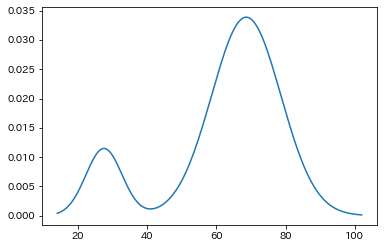

In [293]:
# データ(-6から6までを200こ)
x = sp.linspace(np.min(y), np.max(y), 150)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

plt.savefig(NEW_DIR_PATH +"初期値plot.png")

# EMアルゴリズム

-564.0072538822382
i: 0 lambda [0.1536 0.8464] mu [27.334  68.4894] sigma2 [ 27.8411 105.7417]
-564.8894915377318
i: 1 lambda [0.1527 0.8473] mu [27.2639 68.4124] sigma2 [ 28.5076 107.6547]
-565.6207071179158
i: 2 lambda [0.152 0.848] mu [27.2052 68.3687] sigma2 [ 29.2875 109.3641]
-566.2040130756235
i: 3 lambda [0.1516 0.8484] mu [27.1355 68.3477] sigma2 [ 30.3204 110.4285]
-566.7658050730229
i: 4 lambda [0.1516 0.8484] mu [27.0358 68.3384] sigma2 [ 32.0271 110.889 ]
-567.6855933539653
i: 5 lambda [0.152 0.848] mu [26.867  68.3331] sigma2 [ 35.6767 111.1546]
-569.8192940591673
i: 6 lambda [0.153 0.847] mu [26.5639 68.3274] sigma2 [ 45.4567 111.5255]
-574.984526774509
i: 7 lambda [0.1562 0.8438] mu [26.0762 68.3265] sigma2 [ 73.8945 112.3721]
-583.0604884728195
i: 8 lambda [0.1632 0.8368] mu [26.0206 68.3747] sigma2 [126.9322 114.0068]
-590.2470610915456
i: 9 lambda [0.1719 0.8281] mu [28.8999 68.4344] sigma2 [158.9162 115.6885]
-598.0606505334192
i: 10 lambda [0.1838 0.8162] mu [34.54

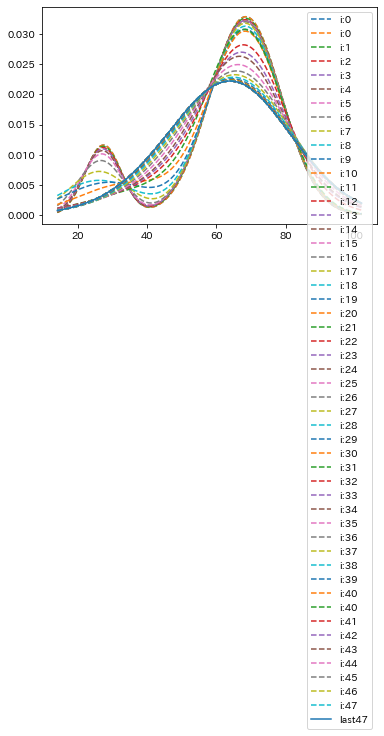

In [294]:
# 100回繰り返す
DIFF=0.000001
old=0
for i in sp.arange(1200+1):
    # Estep # responsibilityの更新 
    responsibility = EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec)
    
    # Mstep # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, coef_vec, sigma2_vec = MStep(k_size, responsibility, y)
    plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
    
    log_likelihood = calc_log_likelihood(X, coef_vec, sigma2_vec, lambda_vec, y)
    print(log_likelihood)
    print("i:", i, "lambda", lambda_vec.round(4), "mu", np.round(mu_vec, 4), "sigma2", sigma2_vec.round(4))
    
    if i !=0:
        diff = abs(log_likelihood - old)
        if diff <DIFF:
            break
    old = log_likelihood

    if i % 40 == 0:
        #print("i:", i, "lambda", lambda_vec.round(4), "mu", np.round(mu_vec, 4), "sigma2", sigma2_vec.round(4))
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.savefig(NEW_DIR_PATH +"EMplot.png")
plt.show()

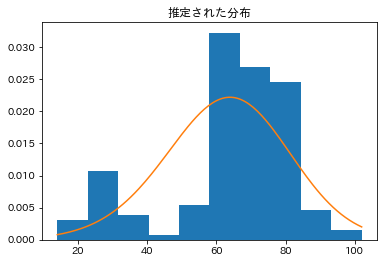

In [295]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")
plt.title("推定された分布")
plt.savefig(NEW_DIR_PATH +"実測値と推定された分布.png")

#### 注  
- mu1, mu2は反転する可能性があるため、f1, f2の混合比率を確認

In [296]:
print("f1の混合比率：", lambda_vec[0])
print("mu1：", mu_vec[0])
print("sigma1", sigma2_vec[0])

print("f2の混合比率：", lambda_vec[1])
print("mu2：", mu_vec[1])
print("sigma2：", sigma2_vec[1])

f1の混合比率： 0.4646726331529172
mu1： 59.090776733752286
sigma1 401.21550209726547
f2の混合比率： 0.5353273668470828
mu2： 66.03548285552033
sigma2： 256.951935925023


###  推定された分布の可視化

Text(0.5, 1.0, '推定された分布の可視化')

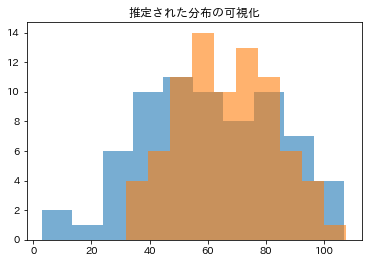

In [297]:
"""# 推定された分布の可視化
new_N1 = stats.norm(loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]))
new_N2 = stats.norm(loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]))

# rvs (Random variates) 確率変数
new_s1 = new_N1.rvs(size=int(lambda_vec[0]*150))
new_s2 = new_N2.rvs(size=int(lambda_vec[1]*150))


#plt.hist(y, bins=30, density=True)

plt.hist(new_s1, density=True, alpha=0.6)
plt.hist(new_s2, density=True, alpha=0.6)

"""
np.random.seed(seed=123)
new_s1 = np.random.normal(loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]), size=int(lambda_vec[0]*150))
new_s2 = np.random.normal(loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]), size=int(lambda_vec[1]*150))
plt.hist(new_s1, density=False, alpha=0.6)
plt.hist(new_s2, density=False, alpha=0.6)
plt.title("推定された分布の可視化")

Text(0.5, 1.0, '推定された分布の可視化')

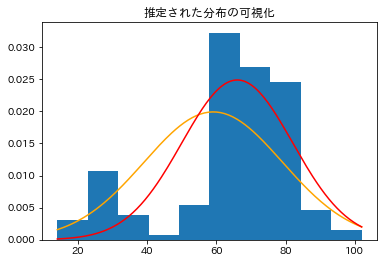

In [298]:
new_N1 = stats.norm.pdf(x, loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]))
new_N2 = stats.norm.pdf(x, loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]))

plt.hist(y, density=True,)
plt.plot(x, new_N1, color="orange")
plt.plot(x, new_N2, color="red")

plt.title("推定された分布の可視化")
#plt.savefig(NEW_DIR_PATH +"分布1と2の可視化.png")

#### 推定されたパラメータ

In [299]:
res_df = pd.DataFrame(coef_vec[0].round(4), index=["Intercept"]+FEATS,  columns=["分布1"])
res_df["分布2"] = coef_vec[1].round(4)
res_df

,分布1,分布2
Intercept,59.0908,66.0355
hf,2.5156,0.6203
pop,1.5756,-3.8024
urb,4.3984,-3.8132
gdp,-2.1799,-1.1321
air,-26.0147,-1.7018
detection,-4.0532,-4.9999
median_age,-6.0740,-3.8268
population_density,-2.2288,-2.1429


# AIC

In [300]:
"""norm1 = 1/(2*np.pi*sigma2_vec[0])**(1/2) * np.exp((-1/2) *((y - X@coef_vec[0]) **2/sigma2_vec[0]) )
norm2 = 1/(2*np.pi*sigma2_vec[1])**(1/2) * np.exp((-1/2) *((y - X@coef_vec[1]) **2/sigma2_vec[1]) )

likelihood = responsibility[0]@np.log(norm1) + responsibility[1]@np.log(norm2) + np.sum(responsibility[0]*np.log( lambda_vec[0])) + np.sum(responsibility[1]*np.log( lambda_vec[1]))
print("対数尤度", likelihood)"""

"""norm1 = stats.norm(loc=X@coef_vec[0], scale=np.sqrt(sigma2_vec[0])).pdf(y)
norm2 = stats.norm(loc=X@coef_vec[1], scale=np.sqrt(sigma2_vec[1])).pdf(y)
likelihood=lambda_vec[0]*norm1 + lambda_vec[1]*norm2
log_likelihood = np.sum(np.log(likelihood))
print("対数尤度", log_likelihood)"""

norm1 = 1/(2*np.pi*sigma2_vec[0])**(1/2) * np.exp((-1/2) *((y - X@coef_vec[0]) **2/sigma2_vec[0]) )
norm2 = 1/(2*np.pi*sigma2_vec[1])**(1/2) * np.exp((-1/2) *((y - X@coef_vec[1]) **2/sigma2_vec[1]) )
log_likelihood = responsibility[0]@np.log(norm1) + responsibility[1]@np.log(norm2) + np.sum(responsibility[0]*np.log( lambda_vec[0])+ responsibility[1]*np.log( lambda_vec[1]))
print("対数尤度", log_likelihood)


対数尤度 -692.7026835633403


In [301]:
k=len(coef_vec[0])+2 + len(coef_vec[1])+2
aic = -2*(log_likelihood)+ 2 *(k)
print("AIC", aic)

AIC 1429.4053671266806


# 決定係数

In [302]:
#y_hat = np.diag(responsibility[0])@X@coef_vec[0]*lambda_vec[0] + np.diag(responsibility[1])@X@coef_vec[1]*lambda_vec[1]
#y_hat = (X@coef_vec[0])*lambda_vec[0] + (X@coef_vec[1])*lambda_vec[1]
y_hat = np.diag(responsibility[0])@(X@coef_vec[0]) + np.diag(responsibility[1])@(X@coef_vec[1])

In [303]:
from sklearn.metrics import r2_score
r2=r2_score( y, y_hat)
print("決定係数", r2)

決定係数 0.6721605107830211


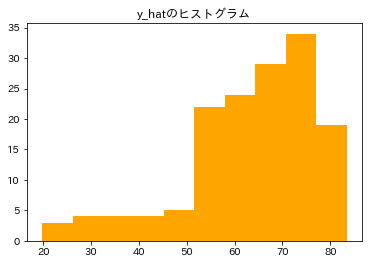

In [304]:
df["y_hat"] = y_hat


plt.hist(df["y_hat"], color="orange")
plt.title("y_hatのヒストグラム")
plt.savefig(NEW_DIR_PATH +"y_hatのヒストグラム.png")

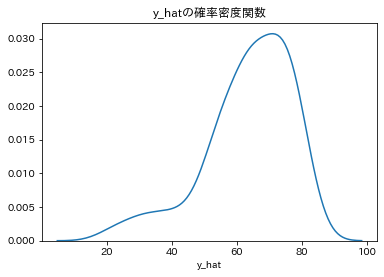

In [305]:
sns.distplot(df["y_hat"], bins=10,hist=False)
plt.title("y_hatの確率密度関数")
plt.savefig(NEW_DIR_PATH +"y_hatの確率密度関数.png")

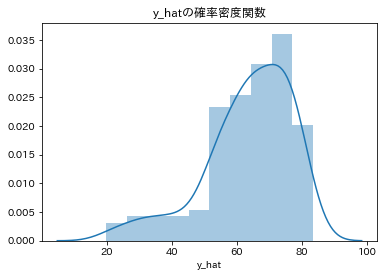

In [306]:
sns.distplot(df["y_hat"], bins=10,hist=True)
plt.title("y_hatの確率密度関数")
plt.savefig(NEW_DIR_PATH +"y_hatの確率密度関数(histあり).png")

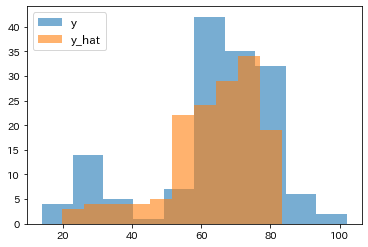

In [307]:
plt.hist(y,  alpha=0.6, label="y")
plt.hist(df["y_hat"],  alpha=0.6, label="y_hat")
#plt.title("y_hatのヒストグラム")
plt.legend(loc="upper left", fontsize=12)
plt.savefig(NEW_DIR_PATH +"yとy_hatのヒストグラム.png")

In [308]:
df["y_hat"].describe()

count    148.000000
mean      63.493243
std       13.552748
min       19.790359
25%       56.521708
50%       65.337139
75%       73.812075
max       83.396860
Name: y_hat, dtype: float64

# その他評価指標

In [309]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y, y_hat))
rmse

10.397571200312148

In [310]:
mse = mean_squared_error(y, y_hat)
mse

108.10948686556063

In [311]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y, y_hat)
mae

7.912539465851163

# 残差の可視化

In [312]:
df["y-y_hat"] = df["date_first"] - df["y_hat"]
df[["country", "date_first", "y_hat", "y-y_hat"]].head()

,country,date_first,y_hat,y-y_hat
0,Albania,70,60.600906,9.399094
1,Algeria,58,72.853499,-14.853499
2,Angola,83,80.056687,2.943313
3,Argentina,65,61.476951,3.523049
4,Australia,26,39.306366,-13.306366


In [313]:
df[['country', 'pop', 'urb', 'gdp', 'dist', 'hf', 'date_first','detection', 'air',  'date_first', 'y_hat', "y-y_hat"]].sort_values("y-y_hat").head(10)

,country,pop,urb,gdp,dist,hf,date_first,detection,air,date_first,y_hat,y-y_hat
94,Nepal,28087871,19.740,3089.556352,2.081805e+06,6.51,26,22.0,3296.95,26,67.897906,-41.897906
23,Cambodia,16249798,23.388,4360.854404,2.643780e+06,7.13,29,57.7,1411.06,29,64.319359,-35.319359
126,Sri Lanka,21670000,18.476,13473.663094,3.971847e+06,6.41,29,43.0,5882.38,29,55.708754,-26.708754
46,Finland,5518050,85.382,48416.936030,5.823421e+06,8.53,31,61.6,13364.84,31,56.493144,-25.493144
108,Philippines,106651922,46.907,8951.085654,3.345565e+06,6.88,31,63.6,43080.12,31,55.036764,-24.036764
83,Malaysia,31528585,76.036,31782.153357,3.678054e+06,6.52,26,73.2,60481.77,26,48.229360,-22.229360
144,Vietnam,95540395,35.919,7447.814334,2.220676e+06,6.29,25,57.4,47049.67,25,46.341082,-21.341082
129,Sweden,10183175,87.431,53208.884360,6.323651e+06,8.50,33,86.0,11623.92,33,51.905445,-18.905445
11,Belgium,11422068,98.001,51407.998337,7.548354e+06,8.29,36,62.5,13639.49,36,54.593872,-18.593872
41,Egypt,98423595,42.704,12412.309401,6.944423e+06,4.50,47,41.5,12340.83,47,64.018203,-17.018203


In [314]:
tmp = df[['country', 'date_first', 'y_hat', "y-y_hat"]].sort_values("y-y_hat").head(10)
tmp.columns=['country', '実測値', '推定値', "残差"]
tmp

,country,実測値,推定値,残差
94,Nepal,26,67.897906,-41.897906
23,Cambodia,29,64.319359,-35.319359
126,Sri Lanka,29,55.708754,-26.708754
46,Finland,31,56.493144,-25.493144
108,Philippines,31,55.036764,-24.036764
83,Malaysia,26,48.229360,-22.229360
144,Vietnam,25,46.341082,-21.341082
129,Sweden,33,51.905445,-18.905445
11,Belgium,36,54.593872,-18.593872
41,Egypt,47,64.018203,-17.018203


In [315]:
df[['country', 'pop', 'urb', 'gdp', 'dist', 'hf', 'date_first','detection', 'air',  'date_first', 'y_hat', "y-y_hat"]].sort_values("y-y_hat", ascending=False).head(10)



,country,pop,urb,gdp,dist,hf,date_first,detection,air,date_first,y_hat,y-y_hat
145,Yemen,28498687,36.642,2575.126385,5.972543e+06,4.30,102,9.0,336.31,102,80.692243,21.307757
119,Sierra Leone,7650154,42.055,1601.974029,1.166188e+07,5.99,93,45.8,50.19,93,74.778942,18.221058
17,Botswana,2254126,69.446,18615.793336,1.061168e+07,7.17,93,28.2,253.42,93,75.731993,17.268007
78,Libya,6678567,80.102,20764.164136,7.927990e+06,4.64,86,36.0,927.15,86,68.740543,17.259457
90,Montenegro,622345,66.813,20689.986751,6.977422e+06,7.43,79,55.4,565.52,79,62.741416,16.258584
95,Netherlands,17231017,91.490,56328.941136,7.432851e+06,8.50,60,86.0,43996.04,60,44.371154,15.628846
135,Turkey,82319724,75.143,28068.859413,5.902979e+06,6.21,73,45.6,115595.50,73,57.472570,15.527430
86,Mauritius,1265303,40.793,23750.988040,7.927009e+06,7.52,81,42.3,1745.29,81,65.520346,15.479654
18,Brazil,209469333,86.569,16096.400962,1.633561e+07,6.48,58,82.4,102109.98,58,42.717390,15.282610
42,El Salvador,6420744,72.023,8331.804142,1.428100e+07,6.89,80,73.9,2545.11,80,64.733440,15.266560


In [316]:
tmp = df[['country', 'date_first', 'y_hat', "y-y_hat"]].sort_values("y-y_hat", ascending=False).head(10)
tmp.columns=['country', '実測値', '推定値', "残差"]
tmp


,country,実測値,推定値,残差
145,Yemen,102,80.692243,21.307757
119,Sierra Leone,93,74.778942,18.221058
17,Botswana,93,75.731993,17.268007
78,Libya,86,68.740543,17.259457
90,Montenegro,79,62.741416,16.258584
95,Netherlands,60,44.371154,15.628846
135,Turkey,73,57.472570,15.527430
86,Mauritius,81,65.520346,15.479654
18,Brazil,58,42.717390,15.282610
42,El Salvador,80,64.733440,15.266560


In [317]:
# 実測値の可視化
fig =px.choropleth(
    df,
    locations="code3",
    color="date_first",
    hover_name="country",
    range_color=[0,102],
    #animation_frame='variable',
    #projection="natural earth",
    color_continuous_scale=list(reversed(px.colors.sequential.OrRd)),
                                )

fig.show()
#plotly.offline.plot(fig, filename='output/実測値の可視化.png')

In [318]:
# 予測値の可視化
fig = px.choropleth(
    df,
    locations="code3",
    color="y_hat",
    hover_name="country",
    #range_color=[0,102],
    #animation_frame='variable',
    #projection="natural earth",
    color_continuous_scale=list(reversed(px.colors.sequential.OrRd)),
                                )
fig.show()
plotly.offline.plot(fig, filename=NEW_DIR_PATH + "y_hatの可視化.html")

'output/exp13/y_hatの可視化.html'

In [319]:
# 残差の可視化
fig = px.choropleth(
    df,
    locations="code3",
    color="y-y_hat",
    hover_name="country",
    #range_color=[0,102],
    #animation_frame='variable',
    #projection="natural earth",
    color_continuous_scale=list(reversed(px.colors.sequential.RdBu)),
                                )
fig.show()
plotly.offline.plot(fig, filename=NEW_DIR_PATH + "残差の可視化.html")

'output/exp13/残差の可視化.html'

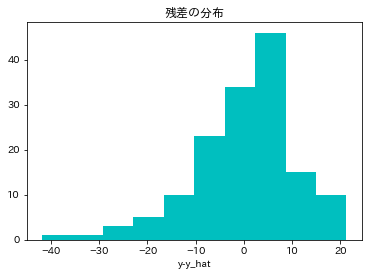

In [320]:
plt.hist(df["y-y_hat"], color="c")
plt.title("残差の分布")
plt.xlabel("y-y_hat")
plt.savefig(NEW_DIR_PATH +"残差の分布.png")

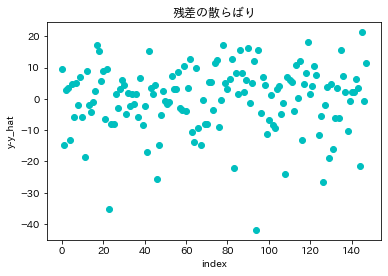

In [321]:
plt.scatter(df.index, df["y-y_hat"], color="c")
plt.title("残差の散らばり")
plt.xlabel("index")
plt.ylabel("y-y_hat")
plt.savefig(NEW_DIR_PATH +"残差の散らばり.png")

In [322]:
# gammaの可視化
df["z"] = responsibility[0].round(2)
fig = px.choropleth(
    df,
    locations="code3",
    color="z",
    hover_name="country",
    #range_color=[0,102],
    #animation_frame='variable',
    #projection="natural earth",
    color_continuous_scale=list(px.colors.sequential.OrRd),
                                )
fig.show()
plotly.offline.plot(fig, filename=NEW_DIR_PATH + "zの可視化.html")

'output/exp13/zの可視化.html'

In [323]:
write_df = pd.DataFrame({
    "実験名":exp_name,
    "memo":memo,
    "説明変数":[FEATS],
    "分布1のβ":[coef_vec[0].round(4)],
    "分布2のβ":[coef_vec[1].round(4)],
    "混合比率":[lambda_vec.round(4)],
    "平均":[np.round(mu_vec, 4)],
    "分散":[np.round(sigma2_vec, 4)],
    "対数尤度":log_likelihood.round(4),
    "パラメータ数":k,
    "AIC":aic.round(4),
    "決定係数":r2.round(4),
    "RMSE":rmse.round(4),
    "MAE":mae.round(4)
})
write_df

,実験名,memo,説明変数,分布1のβ,分布2のβ,混合比率,平均,分散,対数尤度,パラメータ数,AIC,決定係数,RMSE,MAE
0,exp13,"dist除く, 人口密度, 年齢中央値の追加","[hf, pop, urb, gdp, air, detection, median_age...","[59.0908, 2.5156, 1.5756, 4.3984, -2.1799, -26...","[66.0355, 0.6203, -3.8024, -3.8132, -1.1321, -...","[0.4647, 0.5353]","[59.0908, 66.0355]","[401.2155, 256.9519]",-692.7027,22,1429.4054,0.6722,10.3976,7.9125


In [324]:
PATH="output/2成分混合回帰実験管理.xlsx"
excel_df = pd.read_excel(PATH)
excel_df = pd.concat([excel_df, write_df]).reset_index(drop=True)
excel_df.to_excel(PATH, sheet_name = "all", index=False)

write_df.to_excel(PATH, sheet_name = exp_name)

In [325]:
FILE_NAME = "2成分混合回帰モデル_変数選択.ipynb"
f"{NEW_DIR_PATH}{FILE_NAME}"

'output/exp13/2成分混合回帰モデル_変数選択.ipynb'

In [257]:
!cp "2成分混合回帰モデル_変数選択.ipynb" 'output/exp13/2成分混合回帰モデル_変数選択.ipynb'

# t値

In [258]:
sse =  np.sum((y - y_hat) **2, axis=0)
sse = sse / (X.shape[0] - X.shape[1] -1 )
X_tmp = X-X.mean()
ss_ij = np.linalg.inv(X_tmp.T@X_tmp)
std_err2 = np.sqrt(np.diagonal(sse * ss_ij))
std_err2

print("std_err : ", std_err2)

std_err :  [1.08794546 0.98373466 0.94185476 1.02617473 1.09323125 1.07971788
 0.89682332]


In [259]:
t_value1 = coef_vec[0]/std_err2
t_value2 = coef_vec[1]/std_err2

# p値

In [260]:
from scipy import stats
p_values1 =[2*(1-stats.t.cdf(np.abs(i),(len(X)-len(X[0])))) for i in t_value1]
pd.DataFrame(np.round(p_values1, 3))

,0
0,0.000
1,0.093
2,0.000
3,0.000
4,0.006
5,0.015
6,0.116


In [261]:
from scipy import stats
p_values2 =[2*(1-stats.t.cdf(np.abs(i),(len(X)-len(X[0])))) for i in t_value2]
pd.DataFrame(np.round(p_values2, 3))

,0
0,0.000
1,0.002
2,0.207
3,0.024
4,0.000
5,0.000
6,0.004


In [262]:
res_df = pd.DataFrame(coef_vec[0].round(4), index=["Intercept"]+FEATS,  columns=["分布1"])
res_df["分布1_p値"] =np.round(p_values1, 4)
res_df["分布2"] = coef_vec[1].round(4)
res_df["分布2_p値"] =np.round(p_values2, 4)
res_df

,分布1,分布1_p値,分布2,分布2_p値
Intercept,59.7488,0.0000,65.7669,0.0000
pop,1.6657,0.0926,-3.0752,0.0022
dist,6.0528,0.0000,1.1952,0.2065
air,-23.8153,0.0000,-2.3346,0.0244
detection,-3.0673,0.0057,-4.6224,0.0000
median_age,-2.6567,0.0151,-5.8794,0.0000
population_density,-1.4186,0.1159,-2.6450,0.0037


In [61]:
import statsmodels.api as sm
  
model_early = sm.OLS(y_early, sm.add_constant(x_early))
result_early = model_early.fit()
result_early.summary(xname=["Interscept"]+FEATS) 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             date_first   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     2.909
Date:                Wed, 20 Jan 2021   Prob (F-statistic):             0.0396
Time:                        17:14:59   Log-Likelihood:                -57.922
No. Observations:                  23   AIC:                             135.8
Df Residuals:                      13   BIC:                             147.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interscept            37.6484      3.696     10.185      0.000      29.663      45.634
hf                     2.3752      2.148      1.106      0.289      -2.264       7.015
pop                    0.5572      0.435      1.280      0.223      -0.383       1.497
urb                    0.3863      2.247      0.172      0.866      -4.469       5.242
gdp                   -0.3532      3.027     -0.117      0.909      -6.893       6.186
dist                   7.5265      2.338      3.219      0.007       2.475      12.578
air                   -1.4499      0.540     -2.686      0.019      -2.616      -0.284
detection             -2.3927      1.604     -1.492      0.160      -5.858       1.073
median_age            -3.4013      1.899     -1.791      0.097      -7.504       0.701
population_density     0.0296      0.666      0.044      0.965      -1.410       1.469
==============================================================================
Omnibus:                        3.463   Durbin-Watson:                   2.525
Prob(Omnibus):                  0.177   Jarque-Bera (JB):                2.820
Skew:                          -0.758   Prob(JB):                        0.244
Kurtosis:                       2.197   Cond. No.                         19.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
import statsmodels.api as sm
  
model_late = sm.OLS(y_late, sm.add_constant(x_late))
result_late = model_late.fit()
result_late.summary(xname=["Interscept"]+FEATS) 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             date_first   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     15.23
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           4.47e-16
Time:                        17:14:59   Log-Likelihood:                -416.22
No. Observations:                 125   AIC:                             852.4
Df Residuals:                     115   BIC:                             880.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interscept            68.5709      0.746     91.894      0.000      67.093      70.049
hf                     0.5483      1.022      0.536      0.593      -1.476       2.572
pop                   -8.4117      2.242     -3.753      0.000     -12.852      -3.972
urb                   -3.6624      0.965     -3.797      0.000      -5.573      -1.752
gdp                   -1.3434      1.054     -1.275      0.205      -3.431       0.744
dist                   1.0107      0.802      1.260      0.210      -0.578       2.599
air                    4.3057      2.691      1.600      0.112      -1.025       9.636
detection             -2.6044      0.853     -3.053      0.003      -4.294      -0.915
median_age            -2.8683      1.168     -2.455      0.016      -5.183      -0.554
population_density    -0.3947      1.684     -0.234      0.815      -3.729       2.940
==============================================================================
Omnibus:                        5.793   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                7.157
Skew:                           0.243   Prob(JB):                       0.0279
Kurtosis:                       4.067   Cond. No.                         8.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ✅hf, pop, urb, gdp, air, detection, dist_itary

In [69]:
res_df

,分布1,分布2
Intercept,27.8169,68.9503
hf,2.1937,-0.9721
pop,0.3344,-9.8995
urb,-1.0413,-4.3070
gdp,0.4835,-1.9898
air,-0.6551,4.4905
detection,-1.0642,-2.5043
dist_italy,-2.3026,2.5252


In [111]:
k=len(coef_vec[0])+2 + len(coef_vec[1])+2
aic = -2*(log_likelihood)+ 2 *(k)
print("AIC", aic)

AIC 1169.1093682602955


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


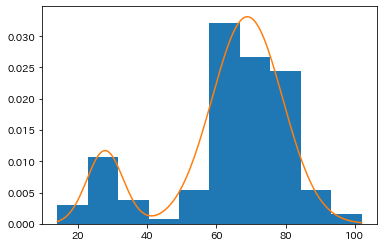

In [72]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

### ✅hf, pop, urb, gdp, air, dist

In [159]:
res_df

,早期感染国,晩期感染国
Intercept,60.2320,68.3693
hf,-6.7426,-1.8981
pop,-1.7336,-7.4032
urb,-4.9434,-4.0617
gdp,-0.5626,-1.3212
air,-3.4071,2.0536
dist,13.1993,1.7964


In [160]:
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,34.144527,68.705715
hf,-0.574947,-2.193724
pop,0.704297,-9.775305
urb,-1.465996,-4.893013
gdp,0.742538,-1.552997
air,-1.592736,3.112941
dist,7.020140,2.045302


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


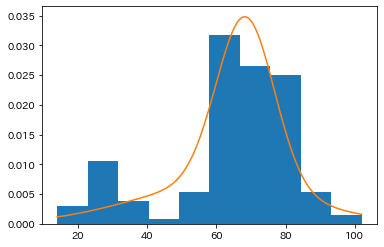

In [161]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

### ✅hf, pop, urb, gdp, air, detection

In [200]:
res_df

,早期感染国,晩期感染国
Intercept,27.6720,68.8998
hf,3.7881,-0.6450
pop,0.3898,-9.3063
urb,-0.2511,-4.0103
gdp,-0.1208,-2.8115
air,-0.6565,4.9016
detection,-2.4609,-2.9686


In [201]:
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,27.706694,68.924369
hf,3.847780,-0.651066
pop,0.389038,-9.473606
urb,-0.212951,-3.997060
gdp,-0.160500,-2.824348
air,-0.655912,5.035802
detection,-2.507140,-2.943951


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


Text(0.5, 1.0, '推定された分布')

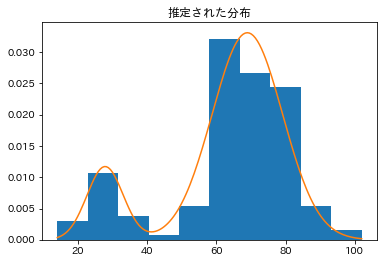

In [133]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")
plt.title("推定された分布")

### ✅hf, pop, urb, gdp, air

In [134]:
res_df

,早期感染国,晩期感染国
Intercept,25.9985,68.8723
hf,2.2768,-1.9647
pop,0.5155,-10.5575
urb,-1.3567,-4.0571
gdp,1.1242,-2.8229
air,-0.9666,3.5627


In [135]:
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,26.053547,68.907071
hf,2.282413,-1.960874
pop,0.516722,-10.823974
urb,-1.277986,-4.032543
gdp,1.067690,-2.843152
air,-0.975720,3.781667


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


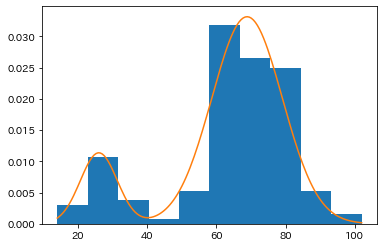

In [136]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

# 改善事項  
- p値  
- 信頼区間  
- AIC  
  
  
- 対数化しない場合  
- 変数選択  
- f1とf2で変数を帰る

# 散布図行列

In [116]:
data = df.copy()
data = data[["date_first", "hf", "pop",  "urb", "gdp","dist", "air", "detection"]]
data["flag"]=0
data.loc[data["date_first"]>40, "flag"]=1

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


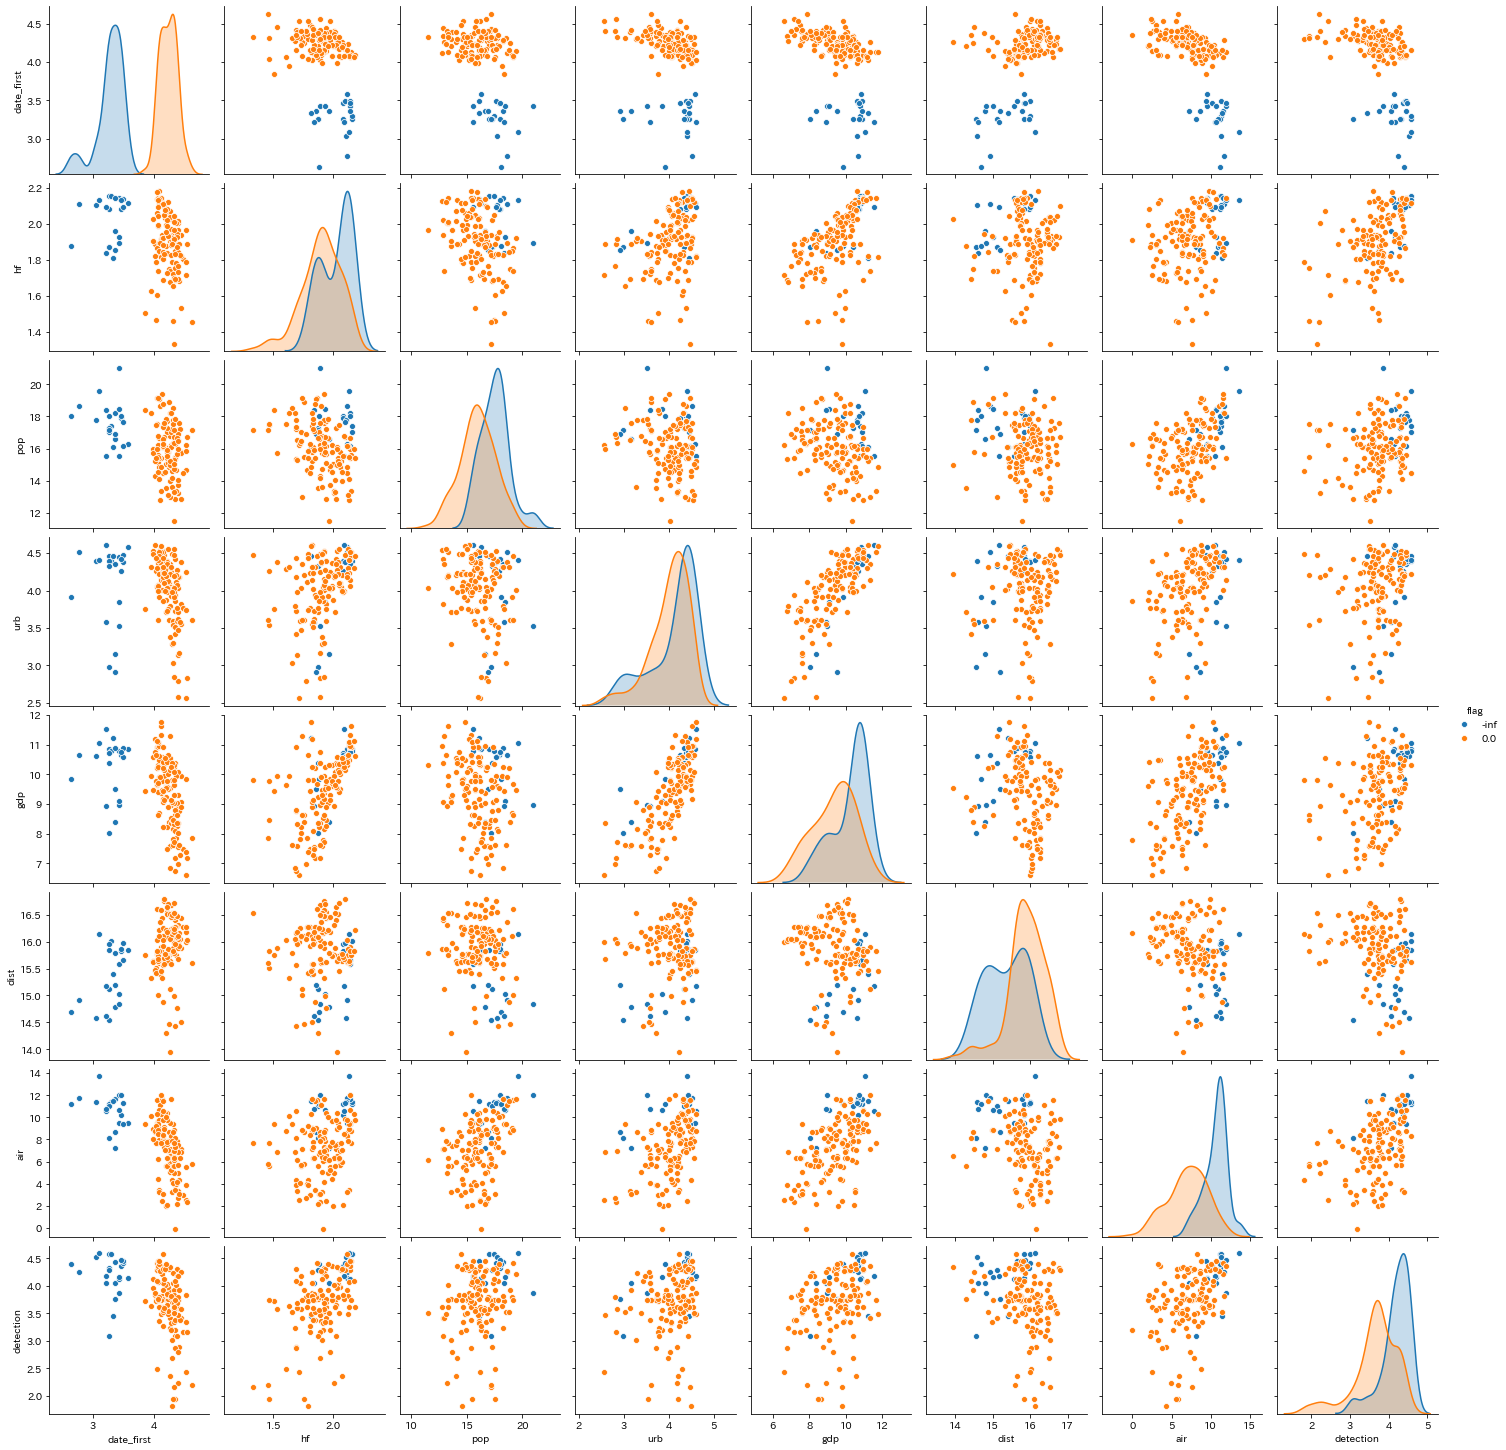

In [26]:
import seaborn as sns
sns.pairplot(np.log(data), hue='flag')